# Titanic Survival Prediction

## Project Overview:
The project involves building a predictive model to determine whether a passenger on the Titanic survived or not. This is a classic machine learning project that uses the Titanic dataset, which contains information about individual passengers, such as their age, gender, ticket class, fare, cabin, and whether or not they survived. The goal is to create a model that can predict passenger survival based on the available data.

## Business Problem:
The business problem is to provide a tool that can help predict the likelihood of a passenger surviving the Titanic disaster. This predictive model can be valuable for historical analysis, understanding the factors that contributed to survival, and potentially for other applications in the future.

### Project Objectives:
* Model Building: Build and train a machine learning model to predict passenger survival. Evaluate the model's performance using appropriate metrics.


# Data Understanding:
The dataset is obtained from Kaggle:[Titanic dataset](https://www.kaggle.com/datasets/brendan45774/test-file)   
The dataset contains the following columns:   
``1. PassengerId``: Unique identifier for each passenger.  
``2. Survived``: Binary variable (0 for not survived, 1 for survived).    
``3. Pclass``: Ticket class (1st, 2nd, 3rd).   
``4. Name``: Passenger's name.   
``5. Sex``: Gender of the passenger.    
``6. Age``: Age of the passenger (some missing values).   
``7. SibSp``: Number of siblings or spouses on board.  
``8. Parch``: Number of parents or children on board.  
``9. Ticket``: Ticket number.   
``10. Fare``: Passenger's fare (some missing values).   
``11. Cabin``: Cabin number (many missing values).   
``12. Embarked``: Port of embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).   


In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve,roc_auc_score,log_loss
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import cross_val_score

In [87]:
class DataProcessor:
    def __init__(self, df):
        # Initialize with a DataFrame.
        self.df = df

    def get_info(self):
        # Get basic DataFrame info 
        return self.df.info()
    
    def get_summary_statistics(self):
        # Get summary statistics for numerical columns.
        return self.df.describe()
    
    def get_dtypes(self):
        # Get data types of columns.
        return self.df.dtypes
    
    def get_mising_values(self):
        # Get the count of missing (null) values in each column.
        return self.df.isnull().sum()
    def get_value_counts(self):
        # Get value counts for all categorical columns.
        categorical_columns = self.df.select_dtypes(include=['object']).columns
        value_counts = {}
        for col in categorical_columns:
            value_counts[col] = self.df[col].value_counts()
        return value_counts
    
    def check_duplicates_in_column(self, column_name):
        # Check for duplicate values in a specific column.
        if column_name in self.df.columns:
            duplicates = self.df[column_name][self.df[column_name].duplicated(keep=False)]
            if not duplicates.empty:
                return duplicates
            else:
                return "No duplicates found in the specified column."
        else:
            return "Column not found in the DataFrame."
        

In [88]:
#preview the dataset
df = pd.read_csv("tested.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,0,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,0,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,1,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [89]:
# Initialize the DataProcessor class
dp = DataProcessor(df)

In [90]:
dp.get_info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Survived     418 non-null    int64  
 2   Pclass       418 non-null    int64  
 3   Name         418 non-null    object 
 4   Sex          418 non-null    object 
 5   Age          332 non-null    float64
 6   SibSp        418 non-null    int64  
 7   Parch        418 non-null    int64  
 8   Ticket       418 non-null    object 
 9   Fare         417 non-null    float64
 10  Cabin        91 non-null     object 
 11  Embarked     418 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 39.3+ KB


In [91]:
dp.get_summary_statistics()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,0.363636,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.481622,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,0.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,0.000000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,0.000000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,1.000000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,1.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [92]:
dp.get_dtypes()

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [93]:
dp.get_value_counts()

{'Name': Kelly, Mr. James               1
 Carr, Miss. Jeannie            1
 Dennis, Mr. William            1
 Rosblom, Miss. Salli Helena    1
 Touma, Miss. Maria Youssef     1
                               ..
 Zakarian, Mr. Mapriededer      1
 Carlsson, Mr. Carl Robert      1
 Dintcheff, Mr. Valtcho         1
 Thomas, Mr. Charles P          1
 Peter, Master. Michael J       1
 Name: Name, Length: 418, dtype: int64,
 'Sex': male      266
 female    152
 Name: Sex, dtype: int64,
 'Ticket': PC 17608    5
 CA. 2343    4
 113503      4
 PC 17483    3
 220845      3
            ..
 349226      1
 2621        1
 4133        1
 113780      1
 2668        1
 Name: Ticket, Length: 363, dtype: int64,
 'Cabin': B57 B59 B63 B66    3
 B45                2
 C89                2
 C55 C57            2
 A34                2
                   ..
 E52                1
 D30                1
 E31                1
 C62 C64            1
 C105               1
 Name: Cabin, Length: 76, dtype: int64,
 'Embar

## Data Cleaning

Dealing with missing values

In [94]:
# chec for missing values
dp.get_mising_values()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

The cabin column has a significant amount of missing values so the column will be dropped

In [95]:
# drop the Cabin column
df = df.drop('Cabin', axis=1)

drop the row with missing values in fare and age

In [96]:
df = df.dropna(subset=['Fare', 'Age'])

In [97]:
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

#### Checking for duplicates
PassengerId will be used here since it is a unuque identifier

In [98]:
# check for duplicates
dp.check_duplicates_in_column('PassengerId')

'No duplicates found in the specified column.'

### check for outliers and drop them

In [99]:
numerical_columns = ['Survived', 'Pclass', 'Age', 'SibSp', 'Fare']

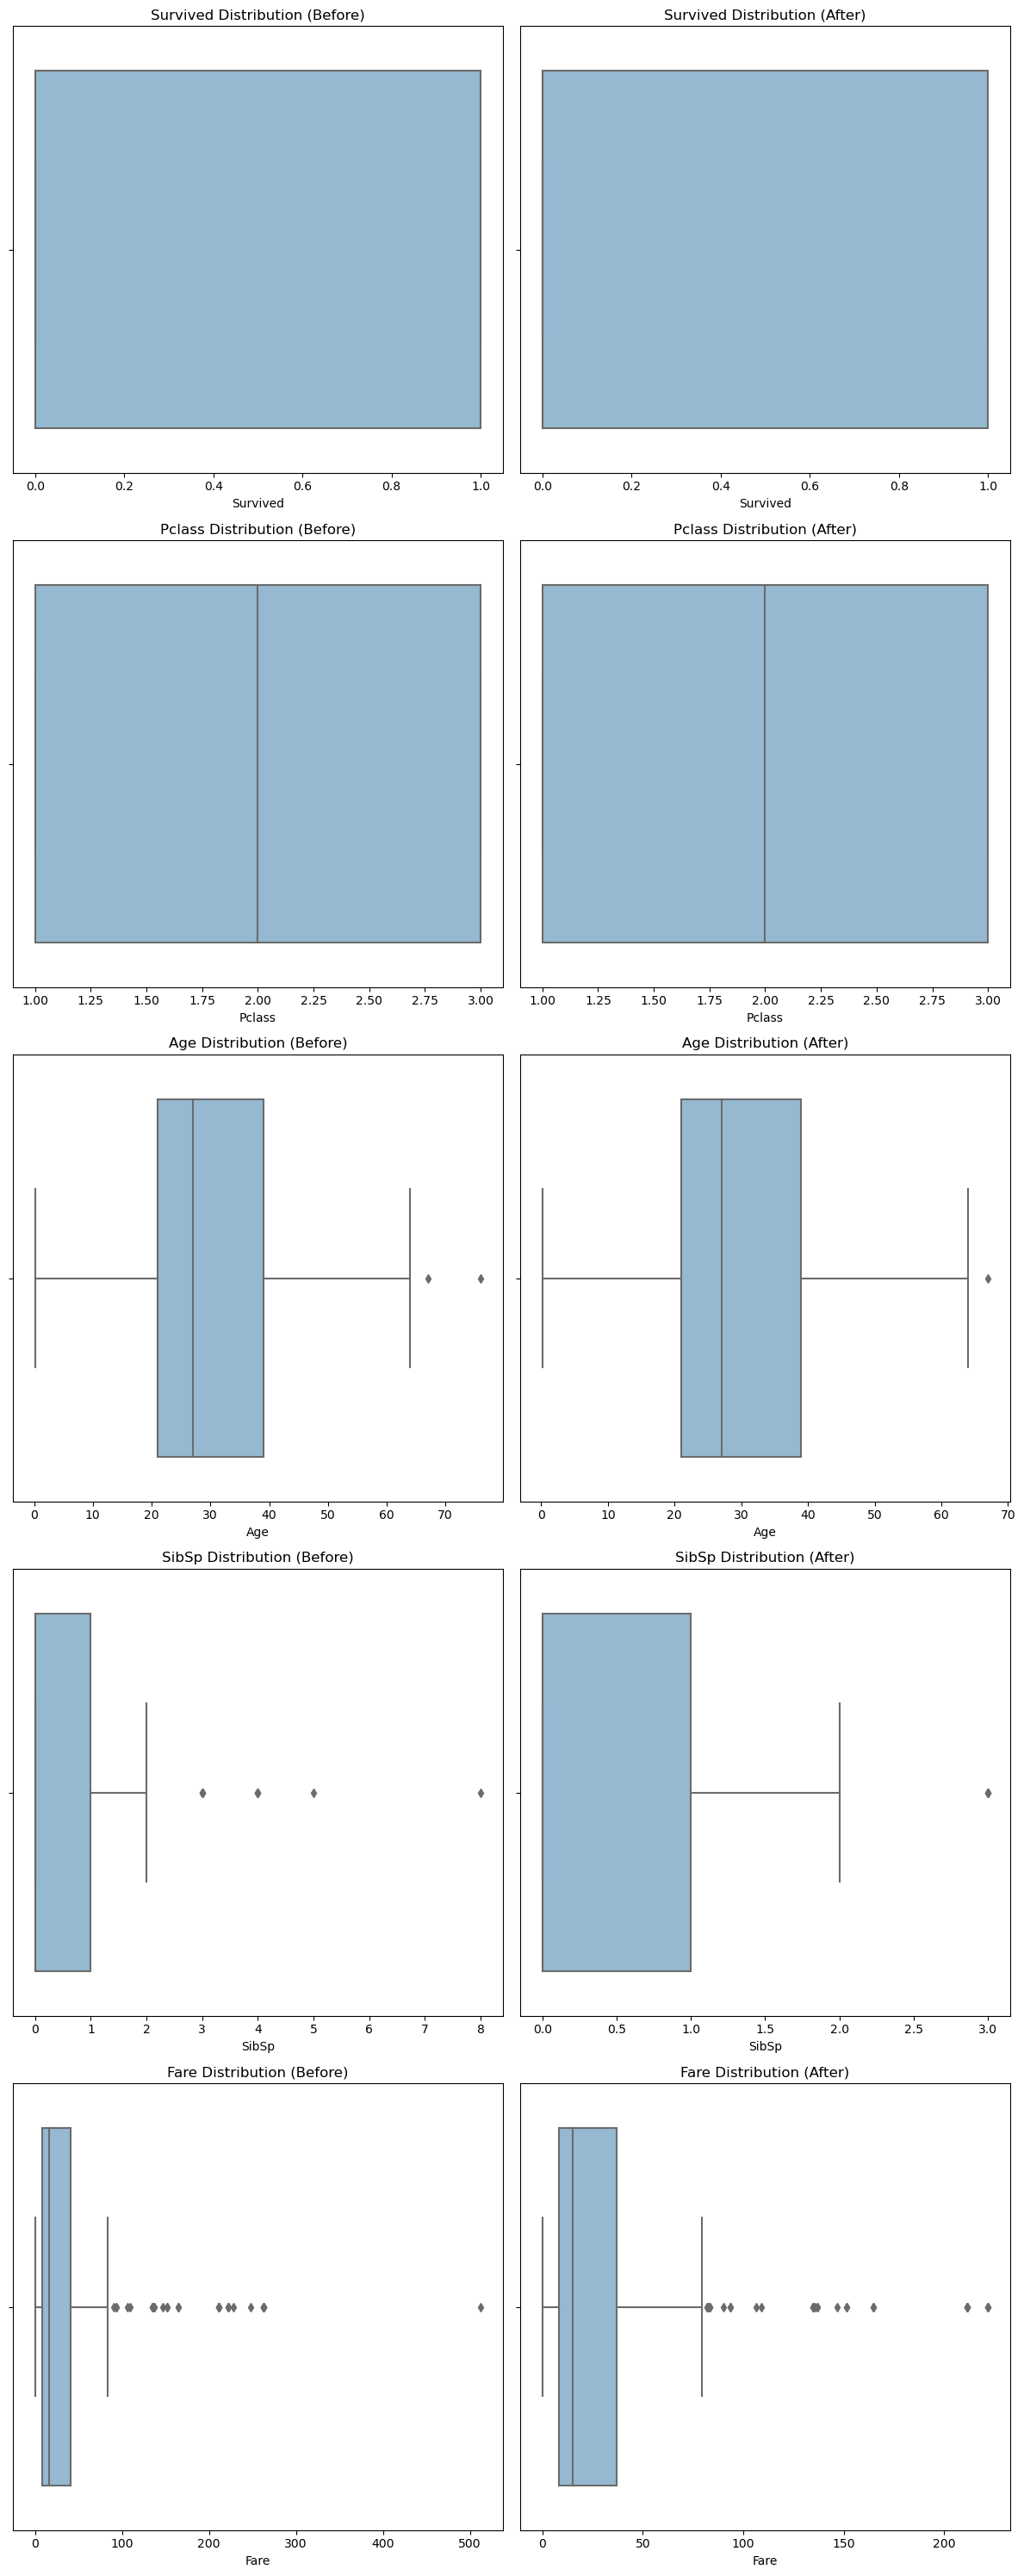

In [100]:
# # Set the plot style to a dark theme
# plt.style.use('dark_background')
# Define a custom color palette with darker shades of blue
custom_palette = sns.color_palette("Blues_d")
sns.set_palette(custom_palette)
# Function to check for outliers by plotting
def outlier_plot_box(df, column_name, ax=None):
    sns.boxplot(x=df[column_name], ax=ax)

# Function to remove outliers
def remove_outliers(data, cols, threshold=3):
    for col in cols:
        z_scores = np.abs(stats.zscore(data[col]))
        data = data[(z_scores < threshold)]
    return data

# Function to plot outliers before and after removal
def plot_outliers_before_and_after(df, numerical_columns, threshold=3):
    fig, axes = plt.subplots(len(numerical_columns), 2, figsize=(12, len(numerical_columns) * 6))

    for i, column in enumerate(numerical_columns):
        ax1 = axes[i][0]
        ax2 = axes[i][1]

        # Plot boxplot before removing outliers
        outlier_plot_box(df, column, ax=ax1)
        ax1.set_title(f"{column} Distribution (Before)")

        # Remove outliers
        df_cleaned = remove_outliers(df, [column], threshold=threshold)

        # Plot boxplot after removing outliers
        outlier_plot_box(df_cleaned, column, ax=ax2)
        ax2.set_title(f"{column} Distribution (After)")

    plt.tight_layout()
    plt.show()

# Call the function to plot outliers before and after removal
plot_outliers_before_and_after(df, numerical_columns)


#### Drop unnecessay column
PassengerId and name is a unique identify and is no needed for the modeling part

In [101]:
df = df.drop(['PassengerId', 'Name'], axis=1)

## Eploratory Data Analysis

### Univariate analysis 
This is analysis of one attribute

#### survival rate 
The dependent variable is the Survive column, which represents whether the passenger survived or not

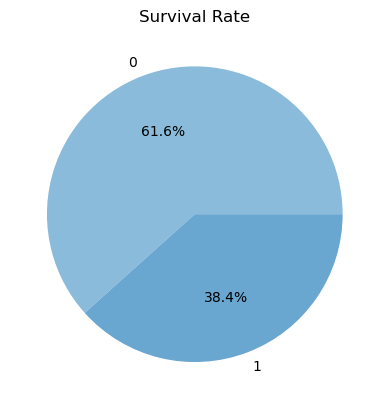

In [103]:
# Plot of Survival Rate
def plot_survival_rate(df):
    #Create a figure
    fig, ax = plt.subplots()

    # Plot the churn rate
    ax.pie(df['Survived'].value_counts(), labels=df['Survived'].value_counts().index, autopct='%1.1f%%')

    # Add a title
    ax.set_title('Survival Rate')

    # Show the plot
    plt.show()
plot_survival_rate(df)  

* $61.6$ % of people did not survive while $38.4$ % percent survived.

#### Distribution Plots for numerical variables

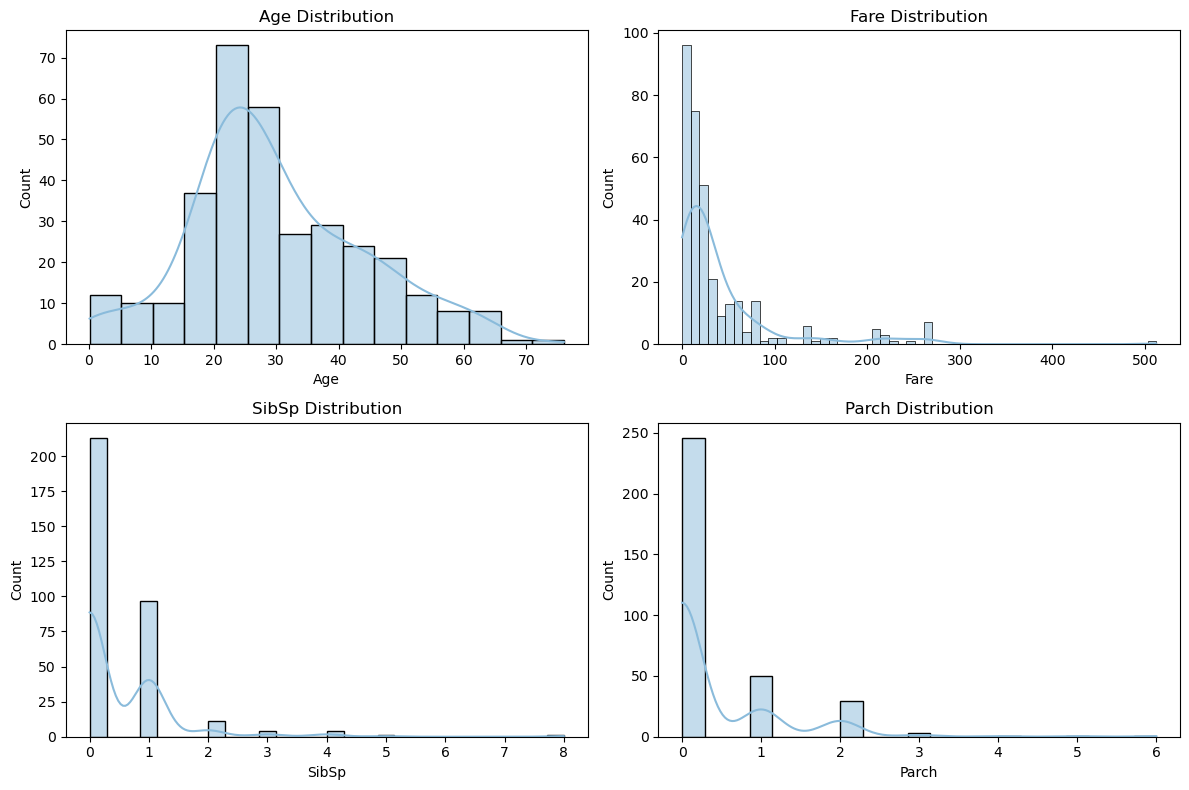

In [104]:
# Distribution plots for numerical variables
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['Age'], kde=True, ax=axes[0, 0]).set_title('Age Distribution')
sns.histplot(df['Fare'], kde=True, ax=axes[0, 1]).set_title('Fare Distribution')
sns.histplot(df['SibSp'], kde=True, ax=axes[1, 0]).set_title('SibSp Distribution')
sns.histplot(df['Parch'], kde=True, ax=axes[1, 1]).set_title('Parch Distribution')
plt.tight_layout()
plt.show()


#### Bar plots for categorical variables

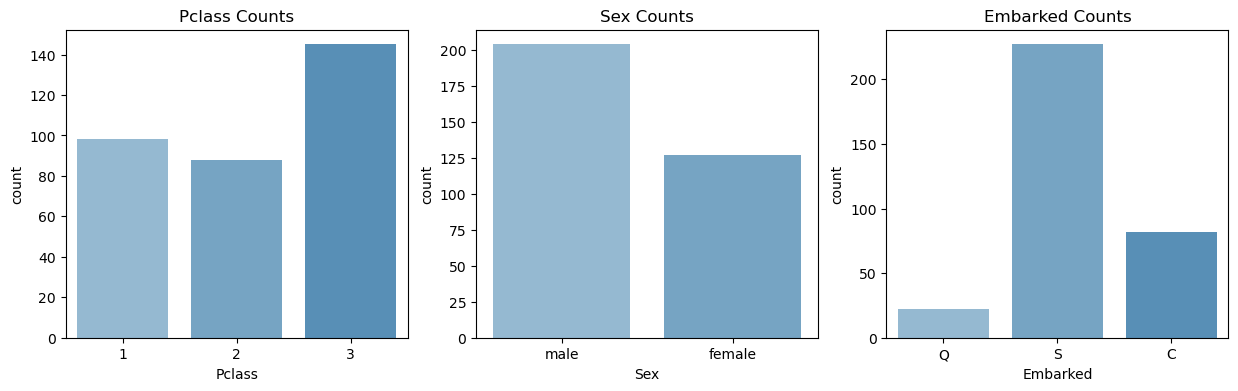

In [105]:
categorical_columns = ['Pclass', 'Sex', 'Embarked']
# Bar plots for categorical variables
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, col in enumerate(categorical_columns):
    sns.countplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f'{col} Counts')
plt.show()



## Bivariate Analysis

Bivariate analysis explores the relationships between pairs of variables.   
Let's investigate how variables interact with each other, specifically with respect to the 'Survived' variable.

#### Survivors by Passenger Class

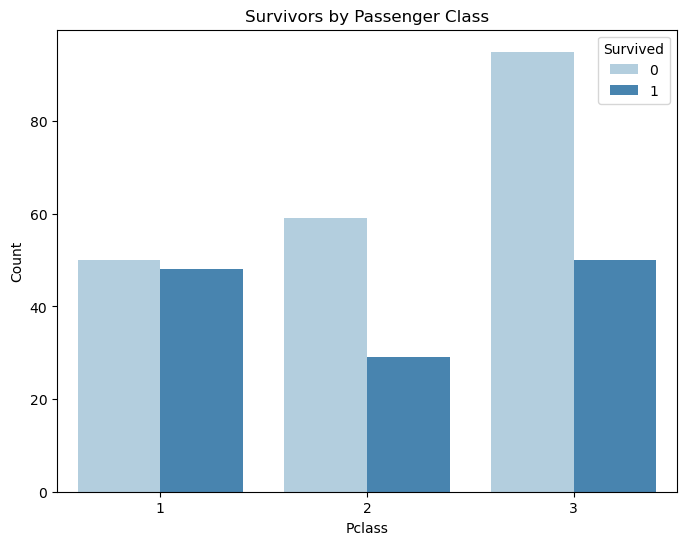

In [106]:
# Bar plot comparing the number of survivors by Pclass
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Pclass', hue='Survived', palette='Blues')
plt.xlabel('Pclass')
plt.ylabel('Count')
plt.title('Survivors by Passenger Class')
plt.show()

#### Correlation Heatmap between Age and Fare

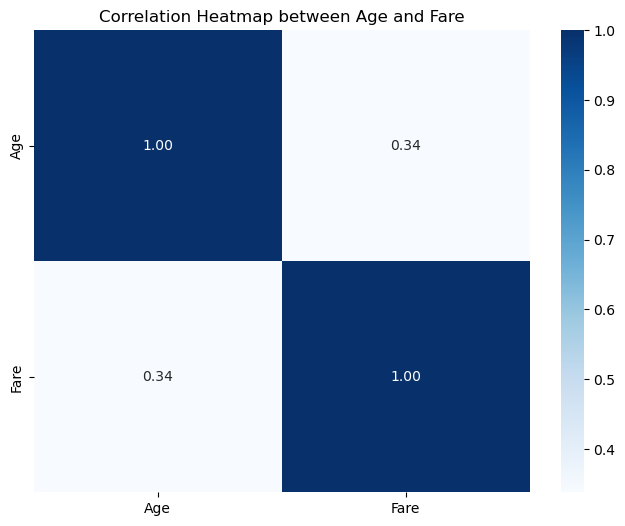

In [107]:
# Correlation heatmap between Age and Fare
correlation_matrix = df[['Age', 'Fare']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap between Age and Fare')
plt.show()

#### 'Correlation Heatmap between Survived and Fare

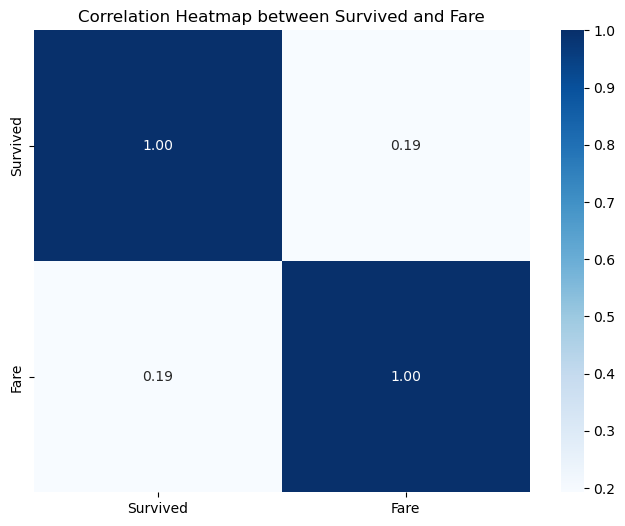

In [108]:
# Correlation heatmap between Survived' and Fare
correlation_matrix = df[['Survived', 'Fare']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues', fmt='.2f')
plt.title('Correlation Heatmap between Survived and Fare')
plt.show()

#### Numeric vs. Survival Analysis

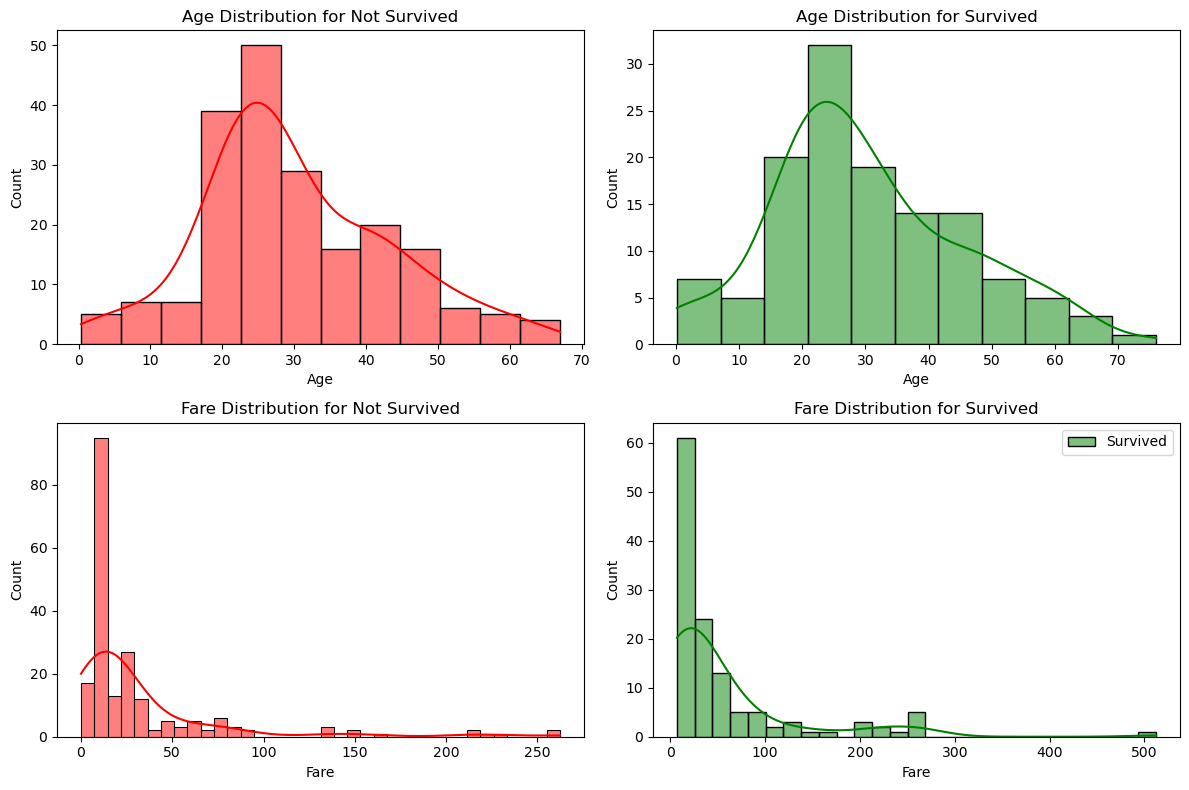

In [109]:
# Numeric vs. Survival Analysis
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df[df['Survived'] == 0]['Age'], kde=True, ax=axes[0, 0], color='red', label='Not Survived').set_title('Age Distribution for Not Survived')
sns.histplot(df[df['Survived'] == 1]['Age'], kde=True, ax=axes[0, 1], color='green', label='Survived').set_title('Age Distribution for Survived')
sns.histplot(df[df['Survived'] == 0]['Fare'], kde=True, ax=axes[1, 0], color='red', label='Not Survived').set_title('Fare Distribution for Not Survived')
sns.histplot(df[df['Survived'] == 1]['Fare'], kde=True, ax=axes[1, 1], color='green', label='Survived').set_title('Fare Distribution for Survived')
plt.legend()
plt.tight_layout()
plt.show()


#### Survival by Age

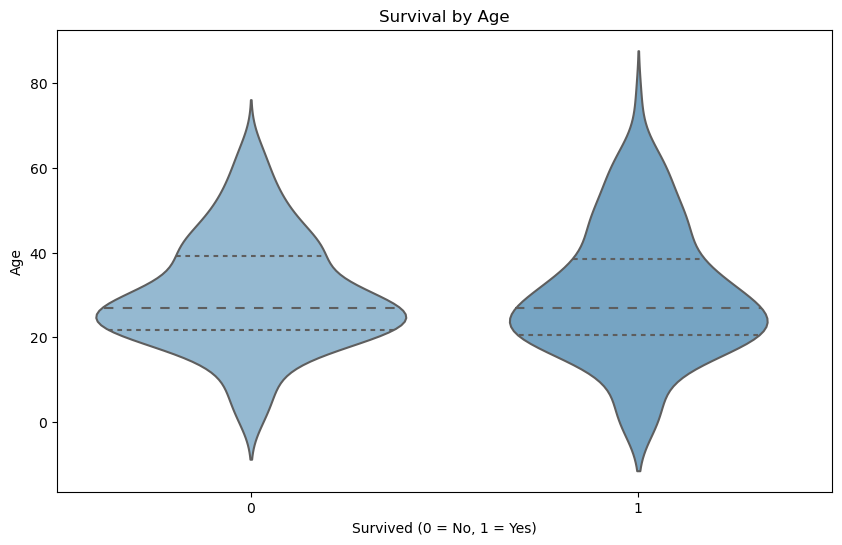

In [110]:
# Create a violin plot to visualize survival by age
custom_palette = sns.color_palette("Blues_d")
plt.figure(figsize=(10, 6))
sns.violinplot(x='Survived', y='Age', data=df, inner='quartile', palette=custom_palette)
plt.title('Survival by Age')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Age')
plt.show()

#### Survival by Fare

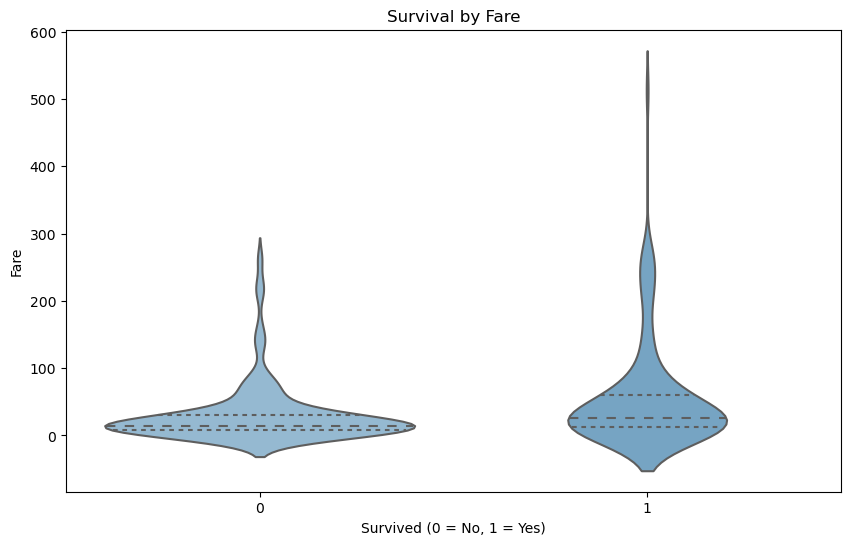

In [111]:
# Create a violin plot to visualize survival by fare with the custom palette
plt.figure(figsize=(10, 6))
sns.violinplot(x='Survived', y='Fare', data=df, inner='quartile', palette=custom_palette)
plt.title('Survival by Fare')
plt.xlabel('Survived (0 = No, 1 = Yes)')
plt.ylabel('Fare')
plt.show()

### Multivariate Analysis

Multivariate analysis considers the interactions of multiple variables. In this section, we'll explore relationships between multiple variables simultaneously.

#### Pair Plots


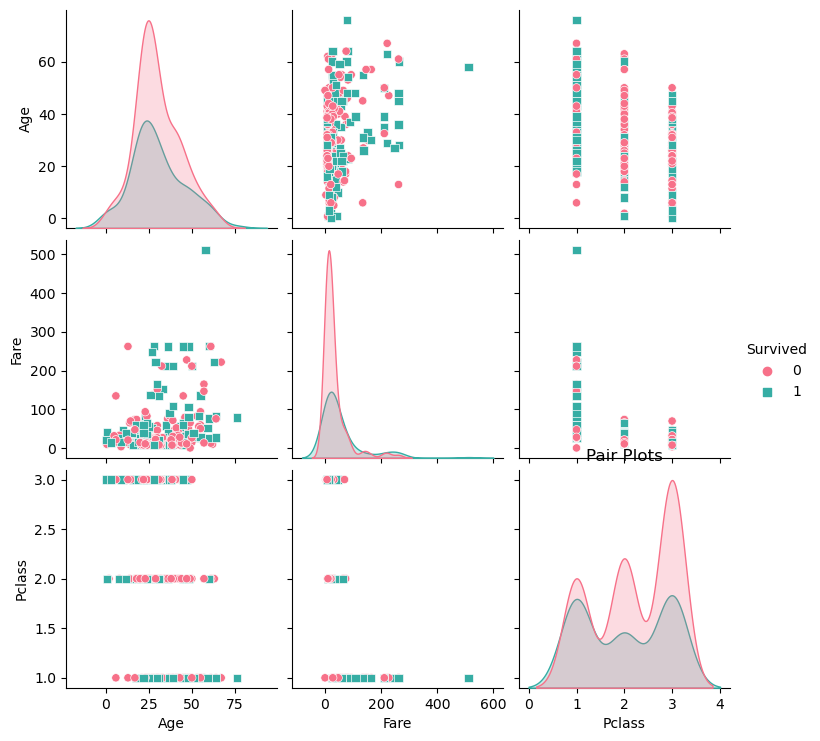

In [112]:
# Pair plots for numerical variables
sns.pairplot(df[['Age', 'Fare', 'Pclass', 'Survived']], hue='Survived', diag_kind='kde', markers=['o', 's'], palette='husl')
plt.title('Pair Plots')
plt.show()

#### Correlation Heatmap

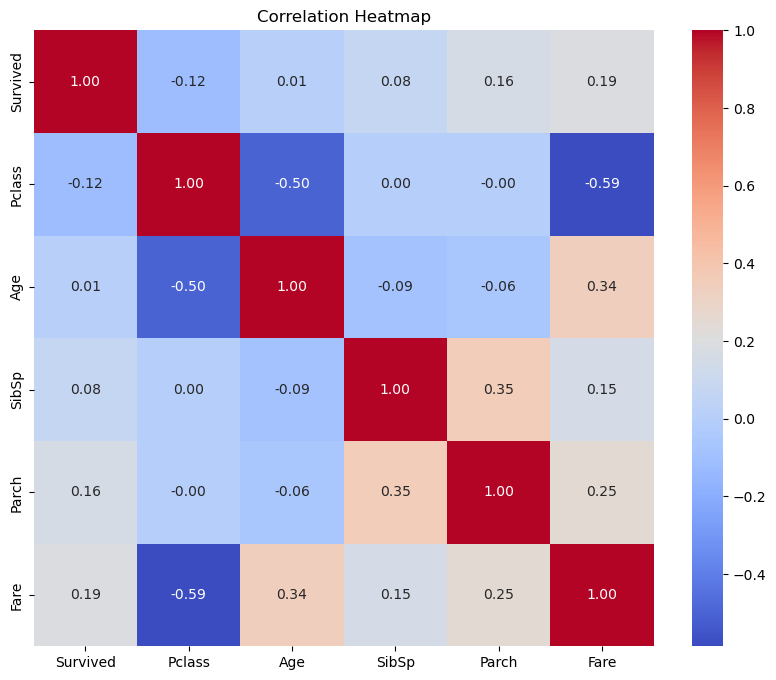

In [113]:
# Correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

## Data Preprocessing

### Assign the variables
assigning y/ target variable to Survived column for prediction and the rest of the features to independent variable X

In [114]:
# Assign the data to X and y
y = df['Survived'] 
X = df.drop(columns=['Survived'], axis=1)

In [115]:
X.head()

,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,3,male,34.5,0,0,330911,7.8292,Q
1,3,female,47.0,1,0,363272,7.0000,S
2,2,male,62.0,0,0,240276,9.6875,Q
3,3,male,27.0,0,0,315154,8.6625,S
4,3,female,22.0,1,1,3101298,12.2875,S


### One-Hot Encoding Categorical Variables

One-hot encoding is used to convert categorical variables into a binary format, which is suitable for machine learning algorithms. In this section, we'll one-hot encode the relevant categorical variables in our dataset.

In [116]:

# Specify the categorical columns to be one-hot encoded
categorical_columns = ['Pclass', 'Sex', 'Embarked']

# Initialize the OneHotEncoder
ohe = OneHotEncoder(sparse=False)

# Fit and transform the categorical columns
X_categorical_encoded = ohe.fit_transform(X[categorical_columns])

# Retrieve feature names for the encoded columns
feature_names = []
for i, col in enumerate(categorical_columns):
    categories = ohe.categories_[i]
    for category in categories:
        feature_names.append(f"{col}_{category}")

# Create a DataFrame for the encoded features
X_categorical_encoded_df = pd.DataFrame(X_categorical_encoded, columns=feature_names)

In [117]:
X_categorical_encoded_df.head()

,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


### Scaling Numerical Features  
Scaling numerical features is important to ensure that they have similar scales, which can improve the performance of machine learning models. In this section, we'll apply Z-score standardization to the selected numerical columns in our dataset.

In [118]:
# Specify the numerical columns to be scaled
numerical_columns = ['Age', 'SibSp', 'Parch', 'Fare']

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the selected numerical columns
X_numeric_scaled = scaler.fit_transform(X[numerical_columns])

# Create a DataFrame for the scaled features
X_numeric_scaled_df = pd.DataFrame(X_numeric_scaled, columns=numerical_columns)

In [119]:
X_numeric_scaled_df.head()

,Age,SibSp,Parch,Fare
0,0.306657,-0.553272,-0.492120,-0.542281
1,1.194236,0.591310,-0.492120,-0.555844
2,2.259331,-0.553272,-0.492120,-0.511885
3,-0.225890,-0.553272,-0.492120,-0.528651
4,-0.580922,0.591310,0.741907,-0.469357


In [120]:
# combine the scaled columns and onehotencoded columns
X_final= pd.concat([X_numeric_scaled_df, X_categorical_encoded_df, ], axis=1)
X_final.head()

,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.306657,-0.553272,-0.492120,-0.542281,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.194236,0.591310,-0.492120,-0.555844,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,2.259331,-0.553272,-0.492120,-0.511885,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,-0.225890,-0.553272,-0.492120,-0.528651,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,-0.580922,0.591310,0.741907,-0.469357,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0


### Train-Test Split

In machine learning, it's common to split the dataset into a training set and a testing set. The training set is used to train the model, while the testing set is used to evaluate its performance. Let's split our dataset to prepare for model training.

In [126]:
# Split the dataset into a training set (80%) and a testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Display the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (264, 12)
X_test shape: (67, 12)
y_train shape: (264,)
y_test shape: (67,)


### SMOTE 

In [127]:
y.value_counts(normalize=True)

0    0.616314
1    0.383686
Name: Survived, dtype: float64

There is data imbalance  although not  severe class imbalance

SMOTE (Synthetic Minority Over-sampling Technique) s specifically designed to handle the imbalanced distribution of the target variable, where the minority class has significantly fewer samples compared to the majority class.  

Smote will be used to resolve the imbalance in the target variable above where 1 has very few samples compared to 0

In [129]:
#instantiate SMOTE 
sm = SMOTE(k_neighbors=5, random_state=42)
# fit sm on the training data
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)
# print training data set before over sampling
print('Before resampling, the shape of X_train: {}'.format(X_train.shape))
print('Before resampling, the shape of y_train: {}'.format(y_train.shape)) 
# print training data set after over sampling
print('After resampling, the shape of X_train_resampled: {}'.format(X_train_resampled.shape))
print('After resampling, the shape of y_train_resampled: {}'.format(y_train_resampled.shape))
y_train_resampled.value_counts()

Before resampling, the shape of X_train: (264, 12)
Before resampling, the shape of y_train: (264,)
After resampling, the shape of X_train_resampled: (318, 12)
After resampling, the shape of y_train_resampled: (318,)


0    159
1    159
Name: Survived, dtype: int64

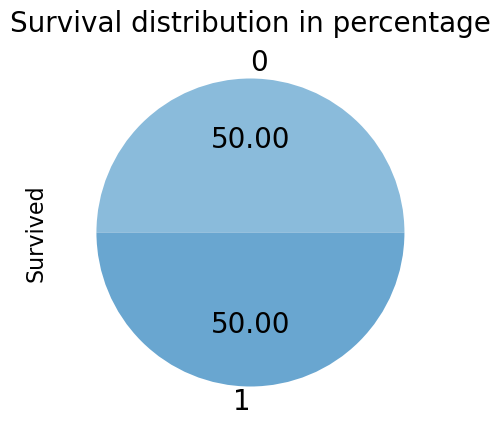

In [131]:
# Create a pie chart showing the distribution of the 'Survived' variable
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the pie chart
y_train_resampled.value_counts().plot(kind='pie', autopct='%.2f', textprops={'fontsize': 20}, colors=custom_palette, ax=ax)

# Set labels and title
ax.set_ylabel('Survived', fontsize=16)
ax.set_title('Survival distribution in percentage', fontsize=20)

plt.show()

The data is balanced 

## Modeling